# Building GPT from scratch by Andrej Karpathy

## Text data

### Encoder and decoder 

In [1]:
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [2]:
print("n_char:", len(text))

n_char: 1115394


In [3]:
chars = sorted(list(set(text)))
vocab_size = (len(chars))
print("".join(chars))
print("vocab size:", vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65


In [4]:
# encode each char by mapping char to integer, manny other methods are possible
stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}

encode = lambda s: [stoi[ch] for ch in s]
decode = lambda l: "".join([itos[i] for i in l])

print(encode("hallo"))
print(decode(encode("hallo")))

[46, 39, 50, 50, 53]
hallo


### Encoding the data 

In [5]:
import torch 

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"



In [6]:
# encode and turn into tensor
data = torch.tensor(encode(text), dtype=torch.long)

In [7]:
# splitting the data 
n = int(0.9 * len(data))
train_data, val_data = data[:n], data[n:]

## Training 

In [8]:
# sampling chunks for more efficiency 
block_size = 8

# example
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [9]:
# so the the input to the model looks like this 
# x being the input 
# y being the target 

x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"at input {context} the target is: {target}")


at input tensor([18]) the target is: 47
at input tensor([18, 47]) the target is: 56
at input tensor([18, 47, 56]) the target is: 57
at input tensor([18, 47, 56, 57]) the target is: 58
at input tensor([18, 47, 56, 57, 58]) the target is: 1
at input tensor([18, 47, 56, 57, 58,  1]) the target is: 15
at input tensor([18, 47, 56, 57, 58,  1, 15]) the target is: 47
at input tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target is: 58


In [10]:
# the model predicts based on context size of 8 thus after 8 character the sequence need to be truncated

In [11]:
# training setup 

torch.manual_seed(1337)
batch_size = 4 # because we want to evaluate more sequences in parallel
block_size = 8 

def get_batch(split):
    data = train_data if split == "train_data" else val_data # which data are we looking at
    ix = torch.randint(len(data) - block_size, (batch_size,)) # generate random start sites for n_batches which are off-set by block_size otherwise system will break later due to insufficient positions after startsite
    x = torch.stack([data[i:i+block_size] for i in ix]) # the context
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # target word
    return x, y

xb, yb = get_batch("train")

print("inputs:")
print(xb.shape)
print(xb)
print("targets:")
print(yb.shape)
print(yb)

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b][:t+1]
        target = yb[b][t]
        print(f"at input {context} the target is: {target}")

inputs:
torch.Size([4, 8])
tensor([[ 6,  1, 52, 53, 58,  1, 58, 47],
        [ 6,  1, 54, 50, 39, 52, 58, 43],
        [ 1, 58, 46, 47, 57,  1, 50, 47],
        [ 0, 32, 46, 43, 56, 43,  1, 42]])
targets:
torch.Size([4, 8])
tensor([[ 1, 52, 53, 58,  1, 58, 47, 50],
        [ 1, 54, 50, 39, 52, 58, 43, 58],
        [58, 46, 47, 57,  1, 50, 47, 60],
        [32, 46, 43, 56, 43,  1, 42, 53]])
at input tensor([6]) the target is: 1
at input tensor([6, 1]) the target is: 52
at input tensor([ 6,  1, 52]) the target is: 53
at input tensor([ 6,  1, 52, 53]) the target is: 58
at input tensor([ 6,  1, 52, 53, 58]) the target is: 1
at input tensor([ 6,  1, 52, 53, 58,  1]) the target is: 58
at input tensor([ 6,  1, 52, 53, 58,  1, 58]) the target is: 47
at input tensor([ 6,  1, 52, 53, 58,  1, 58, 47]) the target is: 50
at input tensor([6]) the target is: 1
at input tensor([6, 1]) the target is: 54
at input tensor([ 6,  1, 54]) the target is: 50
at input tensor([ 6,  1, 54, 50]) the target is: 39


## Bigram model 

Looks at one character and tries to predict the next character

In [12]:
! wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt

--2024-10-06 17:14:23--  https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-10-06 17:14:23 (12.0 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [13]:
with open("names.txt", "r", encoding="utf-8") as f: 
    names = f.read().splitlines()

In [14]:
b = {}
for name in names[:]:
    w = ["<S>"] + list(name) + ["<E>"] 
    for char1, char2 in zip(w, w[1:]):
        bigram = (char1, char2)
        b[bigram] = b.get(bigram, 0) +1

In [15]:
sorted(b.items(), key= lambda kv: -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [16]:
N = torch.zeros((27, 27), dtype=torch.int32)
chars = sorted(list(set("".join(names))))
stoi = {char:i+1 for i, char in enumerate(chars)}
stoi["."] = 0
itos = {i:char for char, i in stoi.items()}



In [17]:
encode = lambda char: stoi[char]
    
for name in names[:]:
    w = ["."] + list(name) + ["."] 
    for char1, char2 in zip(w, w[1:]):
        i = encode(char1)
        j = encode(char2)
        N[i,j] +=1
        

In [18]:
N

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929],
        [6640,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435],
        [ 114,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0],
        [  97,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4],
        [ 516, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1],
        [3983,  679,  121,  153,  384, 1271,   82,

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

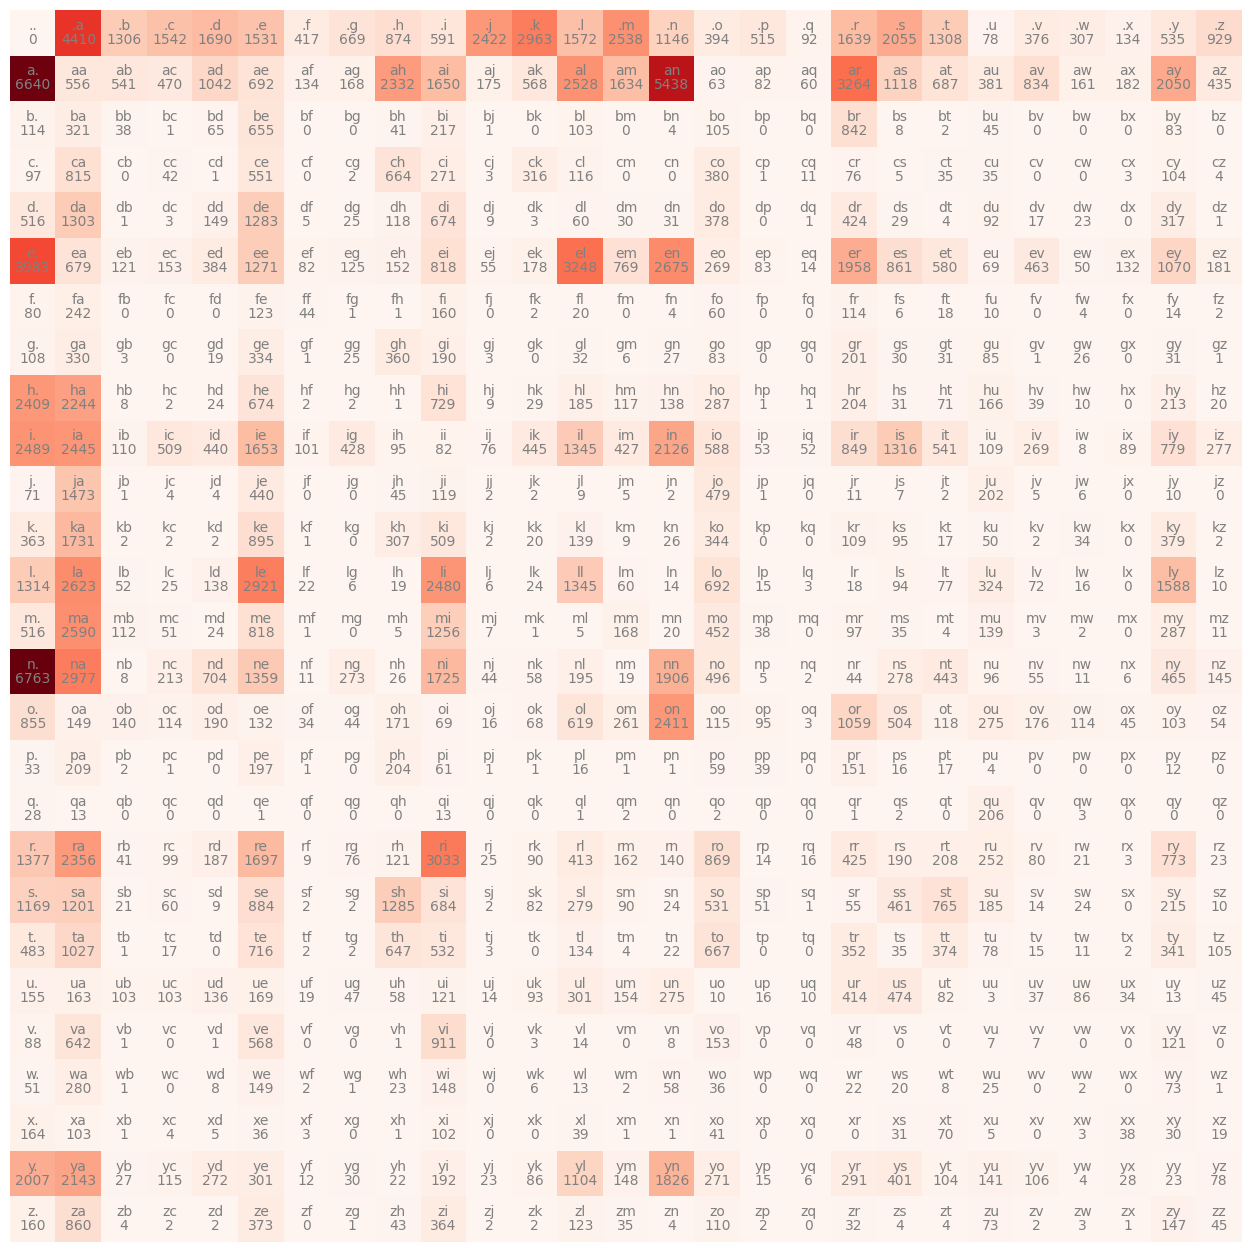

In [19]:
# plot the matrix
import matplotlib.pyplot as plt 

plt.figure(figsize=(16,16))
plt.imshow(N, cmap="Reds")

for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="grey")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="grey")
plt.axis("off")


In [20]:
N[0,:].shape

torch.Size([27])

In [21]:
# convert to probabilities 
p = N[0].float()
p = p / p.sum()

print(f"the probability of being the first char: \n{p.tolist()} ")

the probability of being the first char: 
[0.0, 0.13767053186893463, 0.040770456194877625, 0.048137858510017395, 0.05275809392333031, 0.047794461250305176, 0.013017825782299042, 0.020884713158011436, 0.02728436328470707, 0.018449723720550537, 0.07560952752828598, 0.09249836206436157, 0.04907439276576042, 0.07923079282045364, 0.03577560558915138, 0.012299816124141216, 0.01607717014849186, 0.0028720381669700146, 0.05116598680615425, 0.06415259093046188, 0.040832892060279846, 0.002434988971799612, 0.01173789519816637, 0.009583866223692894, 0.0041831862181425095, 0.016701526939868927, 0.02900134213268757] 


In [22]:
# sample first chars using multinomial distribution 
g = torch.Generator().manual_seed(2010)
ix = torch.multinomial(p, 1, replacement=True, generator=g)


In [23]:
import time 
import pprint

In [24]:
# create names based on each probability distribution 

synth_words = []
i = 0

start = time.time()
for loop in range(10_000):
    synth_word = ""
    while synth_word.endswith(".") is False:
        p = N[i, :].float()
        p = p / p.sum()
        ix = torch.multinomial(p, 1, replacement=True, generator=g)
        synth_word += itos[ix.item()]
        i = ix.item()  

    synth_words.append(synth_word)
end = time.time()
print(end-start)

1.8833911418914795


In [25]:
# we can optimize the system by pre-calculating the probabilities
# we add 1 to the counts to smoothen the model and fix the log likelihood from being infinite for character pairs that do not occure in the dataset

P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [26]:
synth_words = []
i = 0

start = time.time()
for loop in range(10):
    synth_word = ""
    while synth_word.endswith(".") is False:
        ix = torch.multinomial(P[i], 1, replacement=True, generator=g)
        synth_word += itos[ix.item()]
        i = ix.item()  

    synth_words.append(synth_word)
end = time.time()

print(end - start)

0.002145528793334961


In [27]:
# likelihood which is the product of all the probabilities 
# the likelihood of the entire dataset given by the model 
# a good model will assign a high likelihood to the dataset 
# we use log likelihood as the product of probabilities smaller than 1 will results in a tiny number
# since log(a*b*c) = log(a) + log(b) + log(c)
# as we don't want negative numbers we take the -log
# ideally we also normalize to make numbers comparable

In [28]:
# if the model has learned somethhing it will give probabilities higher than 1/27 (uniform probability i.e. each char equally likely)
log_likelihood = 0.0
n = 0
for name in ["llanqkkkkk"]:
    w = ["."] + list(name) + ["."] 
    for char1, char2 in zip(w, w[1:]):
        i = encode(char1)
        j = encode(char2)
        prob = P[i,j]
        logprob = torch.log(prob)
        log_likelihood += logprob
        #print(f"{char1}{char2}\t{prob:.4f}\t{logprob:.4f}")
        n += 1
    
print(-log_likelihood/n)

tensor(4.3505)


In [29]:
# Goal: maximize the likelihood
# thus minimize the negative log likelihood


### Neural network approach to bigrams

In [398]:
# create the training set of all the bigrams

xs, ys = [], []
for name in names[:1]:
    w = ["."] + list(name) + ["."] 
    for char1, char2 in zip(w, w[1:]):
        i = encode(char1)
        j = encode(char2)
        xs.append(i)
        ys.append(j)
        print(char1, char2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [399]:
print(xs,ys, sep="\n")

tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


In [400]:
# as we cant input tensors to the model which as they will differ in length we use one-hot encoding

import torch.nn.functional as F
xenc = F.one_hot(xs , 27).float()
yenc = F.one_hot(xs, 27).float()


In [401]:
xenc.shape

torch.Size([5, 27])

In [402]:
# initialize the weights
W = torch.randn((27,1))

# (5, 1) @ (27, 1) --> (5, 1)
xenc @ W

tensor([[-2.6721],
        [-0.2249],
        [-1.2837],
        [-1.2837],
        [ 0.2299]])

In [403]:
# initialize the weights
W = torch.randn((27,27))

# (5, 1) @ (27, 27) --> (5, 27) for every
xenc @ W


logits = xenc @ W # log-counts since the values have minus signs 
counts = logits.exp() # equivalent N we exponentiase to remove the minus sign 
probs = counts / counts.sum(1, keepdims=True) # we normalize to have everything sum up to one 




In [404]:

xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'



In [405]:
# what have done so far
# 1. we have encoded the name bigrams
# 2. we have turned encodings into one_hot format so vectors will have equal length 
# 3. we have defined a loss that is negative log-likelihood
# 4. we have initialised our first weigths 
# TO DO: we need know how to update the weights in a way that minimizes the loss and maximizes the likelihood

In [482]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647+int(random.uniform(-10, 10)))
W = torch.randn((27, 27), generator=g, requires_grad=True)

xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W # log-counts since the values have minus signs 
counts = logits.exp() # equivalent N we exponentiase to remove the minus sign 
probs = counts / counts.sum(1, keepdims=True) # we normalize to have everything sum up to one 
probs



tensor([[0.0169, 0.0777, 0.0401, 0.0594, 0.0851, 0.0471, 0.0692, 0.0226, 0.0150,
         0.0022, 0.0368, 0.0128, 0.0256, 0.0090, 0.0477, 0.0492, 0.0233, 0.0028,
         0.1208, 0.0133, 0.0135, 0.0176, 0.0361, 0.1026, 0.0078, 0.0211, 0.0249],
        [0.0035, 0.0055, 0.0668, 0.0104, 0.0087, 0.0119, 0.0381, 0.2360, 0.0195,
         0.0243, 0.1087, 0.0033, 0.0567, 0.0188, 0.0492, 0.0103, 0.0145, 0.0226,
         0.0068, 0.0085, 0.0377, 0.0337, 0.0078, 0.0559, 0.0124, 0.0828, 0.0453],
        [0.0516, 0.0082, 0.0809, 0.0983, 0.0075, 0.0312, 0.0047, 0.0729, 0.0100,
         0.0068, 0.2505, 0.0522, 0.0160, 0.0263, 0.0134, 0.0334, 0.0048, 0.0052,
         0.0169, 0.0618, 0.0062, 0.0166, 0.0520, 0.0425, 0.0052, 0.0146, 0.0102],
        [0.0516, 0.0082, 0.0809, 0.0983, 0.0075, 0.0312, 0.0047, 0.0729, 0.0100,
         0.0068, 0.2505, 0.0522, 0.0160, 0.0263, 0.0134, 0.0334, 0.0048, 0.0052,
         0.0169, 0.0618, 0.0062, 0.0166, 0.0520, 0.0425, 0.0052, 0.0146, 0.0102],
        [0.0235, 0.0140,

In [480]:
# calculate the losses

nlls = torch.zeros(5)

for i in range(5):
    x = xs[i].item()
    y = ys[i].item()
    p = probs[i, y]
    logp = torch.log(p)
    nll = -logp
    nlls[i] = nll


In [481]:
sum(nlls)/5

tensor(3.6738, grad_fn=<DivBackward0>)

#### How to tune the weigths 

In [41]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
def f(x):
  return 3*x**2 - 4*x + 5

In [43]:
f(3.0)

20.0

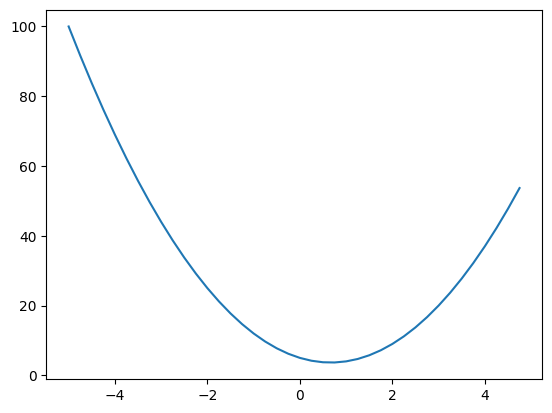

In [44]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)



In [45]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h


2.999378523327323e-06

In [46]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [47]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)



d1 4.0
d2 4.0001
slope 0.9999999999976694


In [360]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __rmul__(self, other):
    return self * other
  
  def __radd__(self, other):
    return self + other
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float power for now"
    out = Value(self.data ** other, (self,), f"**{other}")
    
    def _backward():
      self.grad += other * self.data**(other-1.0) * out.grad
    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other**-1
  
  def __neg__(self):
    return self * -1
  
  def __sub__(self, other):
    return self + (-other)
  

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), "exp")

    def _backward():
      self.grad = out.data * out.grad
    
    out._backward = _backward

    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [361]:
a -b

Value(data=5.0)

In [362]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)


  return dot

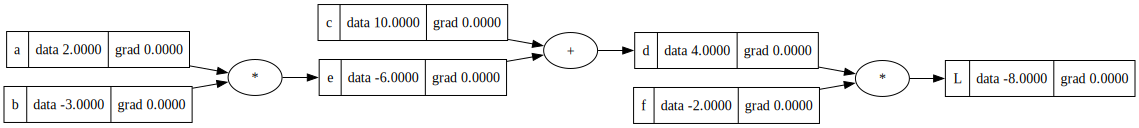

In [363]:
draw_dot(L)

In [364]:


a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b; e.label = "e"; 
d = e + c; d.label = "d"; 
L = d * f; 

print(L.data)



-8.0


how does a neuron work 

1. many inputs $X_n$ flow into network
2. inputs are multiplied by a weight that is $W_n$ before entering the cell body 
3. the cell body sums up the product of $X_iW_i$ and introduces a bias $b$, bias can be thought of as the innate trigger happyness of a neuron
4. before outflow an activation function is performed on the summation 


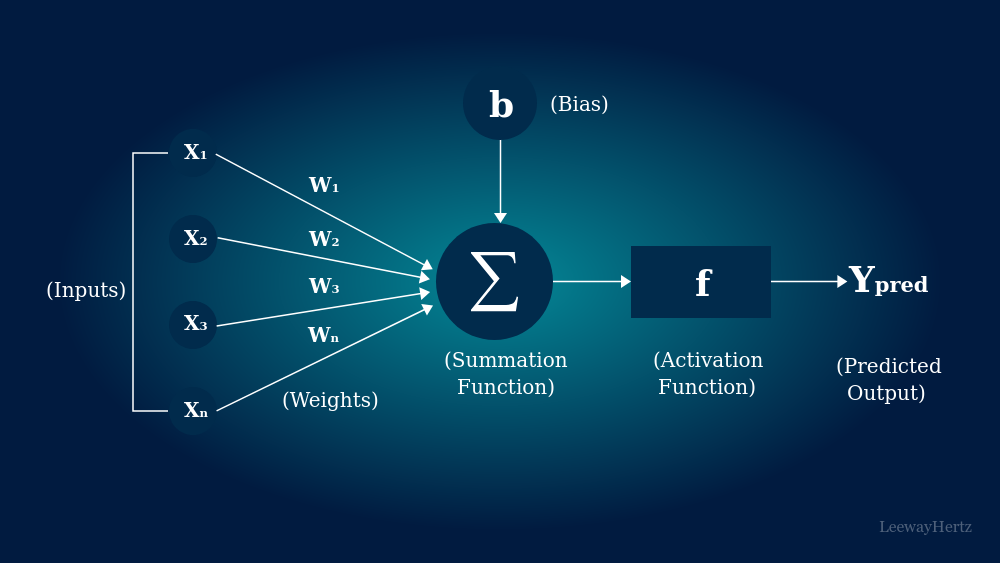

In [365]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'; o.grad=1.0
o.backward()

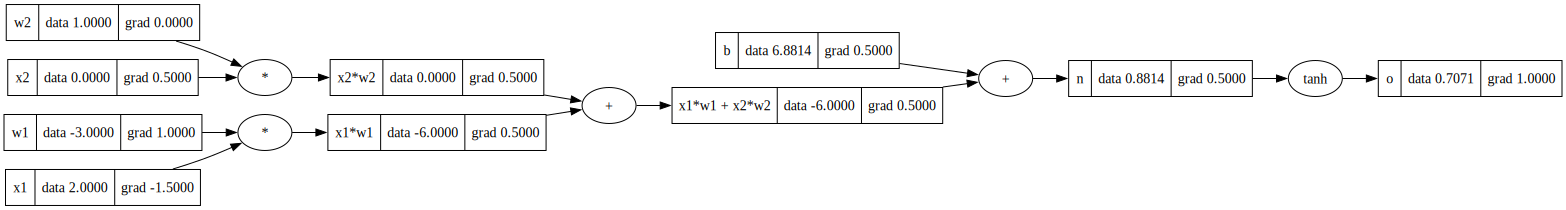

In [366]:
draw_dot(o)

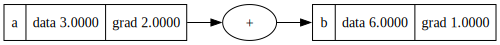

In [367]:
a = Value(3.0, label="a")
b = a + a; b.label="b"
b.backward()
draw_dot(b)
# (a+h) + (a+h) - (a+a) / h = 2h /h = 2

In [368]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----
e = (2*n).exp(); e.label = "e"
o = (e + 1)/( e - 1)
# -----
o.label = "o"
o.grad = 1.0
o.backward()

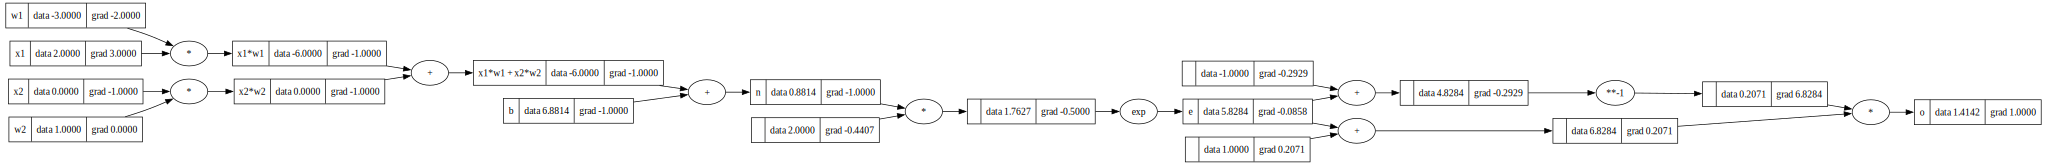

In [369]:
draw_dot(o)

In [370]:
o.data

1.414213562373095

In [371]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [372]:
import random
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # random value between 0 and 1 
    self.b = Value(random.uniform(-1,1)) # trigger happyness
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [373]:
# creating an MLP with 3 inputs and 2 layers of 4 neurons and a single output
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.3805216661182992)

In [374]:
# draw_dot(n(x))

# let's try it out 

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.3805216661182992),
 Value(data=-0.8116211172966687),
 Value(data=-0.5640059508483831),
 Value(data=-0.7030165502556976)]

In [376]:
# how to push the outputs to the actual values 

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print(loss)
# how to minimize the loss ?


Value(data=5.03168285541104)


In [377]:
loss.backward()

In [378]:
n.layers[0].neurons[0].w[0].grad

0.051226103197552886

In [384]:
for k in range(100):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 0.021303018859708603
1 0.02003844535528395
2 0.018906970637565287
3 0.01788913923784167
4 0.0169690609769333
5 0.016133636894737607
6 0.015371977299257444
7 0.014674958747854244
8 0.014034882907852562
9 0.013445211086740648
10 0.012900355630468138
11 0.012395514527192238
12 0.011926539168714705
13 0.011489827797912503
14 0.011082239028457114
15 0.010701021178310158
16 0.010343754157339166
17 0.010008301392854344
18 0.009692769835331334
19 0.009395476509726547
20 0.009114920401006496
21 0.008849758711305649
22 0.008598786719017773
23 0.008360920620705668
24 0.008135182855027446
25 0.007920689501413383
26 0.0077166394206067985
27 0.007522304863659868
28 0.007337023323789642
29 0.0071601904441302
30 0.006991253825781968
31 0.006829707606139945
32 0.006675087698440485
33 0.006526967600706821
34 0.00638495469651691
35 0.006248686981826443
36 0.0061178301619116806
37 0.00599207507070706
38 0.005871135371697453
39 0.005754745505313224
40 0.00564265885266043
41 0.005534646089552798
42 0.0054

In [386]:
print(ypred)
print(loss)

[Value(data=0.9795072487051867), Value(data=-0.9857931763282561), Value(data=-0.9679380197072881), Value(data=0.9697389116216509)]
Value(data=0.0025654907446035938)


In [387]:
#draw_dot(loss)


#### Most Common Neural Net Mistakes:

1. **You didn't try to overfit a single batch first**:
   - **Explanation**: Before training on a full dataset, it's often useful to test your model on a single batch of data to ensure it can overfit that batch. If the model can't overfit even a small batch, it likely means something is wrong with the model's architecture, loss function, or optimization process. Overfitting a batch ensures that your model has the capacity to learn, and issues related to underfitting or improper setup are identified early.

2. **You forgot to toggle train/eval mode for the net**:
   - **Explanation**: In neural networks, certain layers like `Dropout` and `BatchNorm` behave differently during training and evaluation. In PyTorch, for instance, you need to use `model.train()` during training and `model.eval()` during evaluation/inference. If you don't switch modes appropriately, `Dropout` will keep dropping nodes and `BatchNorm` will use running statistics instead of the current batch's statistics, leading to incorrect model behavior during evaluation.

3. **You forgot to .zero_grad(): this leads to the gradients accumulating**:
   - **Explanation**: Optimizers like those in PyTorch accumulate gradients by default. If you don’t reset the gradients (`optimizer.zero_grad()`) before computing new gradients in each training step, the gradients from previous batches will accumulate, leading to incorrect and inflated updates. This can cause erratic training behavior, with the model either failing to converge or performing poorly.

4. **You passed softmaxed outputs to a loss that expects raw logits**:
   - **Explanation**: Many loss functions, such as `CrossEntropyLoss`, expect raw logits as input, not probabilities (softmaxed outputs). Softmax squashes the outputs, which can lead to precision issues and numerically unstable calculations. If you pass softmaxed outputs to such loss functions, it can result in poor learning behavior. Always ensure that the correct input type is passed to the loss function—use raw logits and let the loss function handle the softmax internally, if necessary.


###